In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
# http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

import boto3
import sagemaker.amazon.common as smac

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


### PCA works with numerical value, not compatible with categorical values

In [2]:
columns = ['count', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'year', 'month', 'day', 'dayofweek','hour']

cols_normalize = ['temp','atemp','humidity','windspeed']

In [3]:
df = pd.read_csv('../xgBoost/bikeSharing/train.csv', parse_dates=['datetime'])
df_test = pd.read_csv('../xgBoost/bikeSharing/test.csv', parse_dates=['datetime'])

In [4]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [5]:
# We need to convert datetime to numeric for training.
# Let's extract key features into separate numeric columns
def add_features(df):
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['dayofweek'] = df['datetime'].dt.dayofweek
    df['hour'] = df['datetime'].dt.hour

In [6]:
add_features(df)
add_features(df_test)

In [7]:
df.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,dayofweek,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,5,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,5,1


In [8]:
#normalize dataset
transformer = Normalizer()
transformer.fit(df[cols_normalize])

Normalizer()

In [9]:
def transform_data(scaler, df, columns):
    transformed_data = scaler.transform(df[columns])
    df_transformed = pd.DataFrame(transformed_data, columns=columns)
    
    for col in df_transformed.columns:
        df[col] = df_transformed[col]

In [10]:
transform_data(transformer,df,cols_normalize)
transform_data(transformer, df_test, cols_normalize)

In [11]:
df.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,dayofweek,hour
0,2011-01-01 00:00:00,1,0,0,1,0.118761,0.173736,0.977605,0.0,3,13,16,2011,1,1,5,0
1,2011-01-01 01:00:00,1,0,0,1,0.110467,0.166986,0.979751,0.0,8,32,40,2011,1,1,5,1


In [87]:
# Store Original train and test data in normalized form
df.to_csv('train_normalized.csv',index=False, columns=columns)
df_test.to_csv('test_normalized.csv',index=False)

In [13]:
def write_recordio_file (filename, x, y=None):
    with open(filename, 'wb') as f:
        smac.write_numpy_to_dense_tensor(f, x, y)

In [14]:
# Store All Normalized data as RecordIO File for PCA Training in SageMaker
# Need to pass as an array to create RecordIO file
X = df[['temp','atemp','humidity','windspeed']].values
write_recordio_file('bike_train_numeric_columns.recordio',X)

### Cloud Training

In [15]:
import numpy as np
import pandas as pd

import boto3
import re

import sagemaker
from sagemaker import get_execution_role

In [16]:
bucket_name = 'swati-ml-sagemaker'
training_file_key = 'biketrain1/bike_train_numeric_columns.recordio'

s3_model_output_location = r's3://{0}/biketrain1/model'.format(bucket_name)
s3_training_file_location = r's3://{0}/{1}'.format(bucket_name,training_file_key)

In [17]:
print(s3_model_output_location)
print(s3_training_file_location)

s3://swati-ml-sagemaker/biketrain1/model
s3://swati-ml-sagemaker/biketrain1/bike_train_numeric_columns.recordio


In [18]:
# Write and Reading from S3 is just as easy
# files are referred as objects in S3.  
# file name is referred as key name in S3
# Files stored in S3 are automatically replicated across 3 different availability zones 
# in the region where the bucket was created.

# http://boto3.readthedocs.io/en/latest/guide/s3.html
def write_to_s3(filename, bucket, key):
    with open(filename,'rb') as f: # Read in binary mode
        return boto3.Session().resource('s3').Bucket(bucket).Object(key).upload_fileobj(f)

In [19]:
write_to_s3('bike_train_numeric_columns.recordio',bucket_name,training_file_key)

In [20]:
# We will use spot for training
use_spot_instances = True
max_run = 3600 # in seconds
max_wait = 3600 if use_spot_instances else None # in seconds

job_name = 'pca-biketrain-v2'

checkpoint_s3_uri = None

if use_spot_instances:
    checkpoint_s3_uri = f's3://{bucket_name}/biketrain1/checkpoints/{job_name}'
    
print (f'Checkpoint uri: {checkpoint_s3_uri}')

Checkpoint uri: s3://swati-ml-sagemaker/biketrain1/checkpoints/pca-biketrain-v2


In [21]:
sess = sagemaker.Session()

In [22]:
role = get_execution_role()
print(role)

arn:aws:iam::637423580352:role/service-role/AmazonSageMaker-ExecutionRole-20240325T165146


In [23]:
# SDK 2 uses image_uris.retrieve the container image location

# PCA
container = sagemaker.image_uris.retrieve("pca",sess.boto_region_name)

print (f'Using pca Container {container}')

Using pca Container 382416733822.dkr.ecr.us-east-1.amazonaws.com/pca:1


### Build model

In [24]:
# SDK 2.0
estimator = sagemaker.estimator.Estimator(container,
                                          role, 
                                          instance_count=1, 
                                          instance_type='ml.m5.xlarge',
                                          output_path=s3_model_output_location,
                                          sagemaker_session=sess,
                                          base_job_name = job_name,
                                          use_spot_instances=use_spot_instances,
                                          max_run=max_run,
                                          max_wait=max_wait,
                                          checkpoint_s3_uri=checkpoint_s3_uri)

In [25]:
# Specify hyper parameters that appropriate for the training algorithm
estimator.set_hyperparameters(feature_dim=4,
                        num_components=3,
                        subtract_mean=False,
                        algorithm_mode='regular',
                        mini_batch_size=200)

In [26]:
estimator.fit({'train':s3_training_file_location})

INFO:sagemaker:Creating training-job with name: pca-biketrain-v2-2024-05-21-13-56-29-140


2024-05-21 13:56:29 Starting - Starting the training job...
2024-05-21 13:56:43 Starting - Preparing the instances for training...
2024-05-21 13:57:14 Downloading - Downloading input data...
2024-05-21 13:57:34 Downloading - Downloading the training image......
2024-05-21 13:58:50 Training - Training image download completed. Training in progress.
2024-05-21 13:58:50 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
[05/21/2024 13:58:46 INFO 140149327722304] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-conf.json: {'algorithm_mode': 'regular', 'subtract_mean': 'true', 'extra_components': '-1', 'force_dense': 'true', 'epochs': 1, '_log_level': 'info', '_kvstore': 'dist_sync', '_n


2024-05-21 13:59:03 Completed - Training job completed
Training seconds: 109
Billable seconds: 48
Managed Spot Training savings: 56.0%


In [27]:
# Ref: http://sagemaker.readthedocs.io/en/latest/estimators.html
predictor = estimator.deploy(initial_instance_count=1,
                             instance_type='ml.m5.xlarge',
                             endpoint_name = job_name)

INFO:sagemaker:Creating model with name: pca-biketrain-v2-2024-05-21-13-59-41-428
INFO:sagemaker:Creating endpoint-config with name pca-biketrain-v2
INFO:sagemaker:Creating endpoint with name pca-biketrain-v2


------!

### PCA Projection

In [37]:
# Find PCA
pca = PCA(n_components=0.9) # Capture 90% total variation
# Find new components
pca.fit(df[cols_normalize])

PCA(n_components=0.9)

In [38]:
# No. of PCA Components
print ('Variance: ', pca.n_components)
print ('No. of components to keep: ', pca.n_components_)

Variance:  0.9
No. of components to keep:  2


In [39]:
def transform_with_pca(pca, df, columns):
    transformed_data = pca.transform(df[columns])
    
    tcols = []
    for i in range(pca.n_components_):       
        tcols.append('component_' + str(i))
    
    print ('components:',tcols)
    df_transformed = pd.DataFrame(transformed_data, columns=tcols)
    
    for col in df_transformed.columns:
        df[col] = df_transformed[col]
    
    df.drop(columns, inplace=True, axis=1)
    
    return tcols

In [40]:
new_cols = transform_with_pca(pca, df, cols_normalize)

components: ['component_0', 'component_1']


In [41]:
transform_with_pca(pca, df_test, cols_normalize)

components: ['component_0', 'component_1']


['component_0', 'component_1']

In [42]:
df.head(2)

,count,season,holiday,workingday,weather,year,month,day,dayofweek,hour,component_0,component_1
0,16,1,0,0,1,2011,1,1,5,0,-0.314289,-0.084417
1,40,1,0,0,1,2011,1,1,5,1,-0.323481,-0.080062


In [43]:
for col in new_cols:
    columns.append(col)

In [44]:
columns

['count',
 'season',
 'holiday',
 'workingday',
 'weather',
 'year',
 'month',
 'day',
 'dayofweek',
 'hour',
 'component_0',
 'component_1']

### Training and validation

In [45]:
# Training = 70% of the data
# Validation = 30% of the data
# Randomize the datset
np.random.seed(5)
l = list(df.index)
np.random.shuffle(l)
df = df.iloc[l]

In [46]:
rows = df.shape[0]
train = int(.7 * rows)
test = int(.3 * rows)

In [47]:
rows, train, test

(10886, 7620, 3265)

In [48]:
df[:train].to_csv('bike_train_pca.csv'
                          ,index=False,header=False
                          ,columns=columns)

In [49]:
# Write Validation Set
df[train:].to_csv('bike_validation_pca.csv'
                          ,index=False,header=False
                          ,columns=columns)

In [50]:
# Test Data has only input features
df_test.to_csv('bike_test_pca.csv',index=False)

In [52]:
columns

['count',
 'season',
 'holiday',
 'workingday',
 'weather',
 'year',
 'month',
 'day',
 'dayofweek',
 'hour',
 'component_0',
 'component_1']

In [54]:
# Write Column List
with open('bike_train_column_list_pca.txt','w') as f:
    f.write(','.join(columns))

### PCA Cloud Prediction

In [55]:
import boto3
import re
from sagemaker import get_execution_role
import sagemaker

# SDK 2 serializers and deserializers
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

In [56]:
# Create a predictor and point to an existing endpoint

endpoint_name = 'pca-biketrain-v2'
predictor = sagemaker.predictor.Predictor(endpoint_name=endpoint_name)

In [57]:
predictor.serializer = CSVSerializer()
predictor.deserializer = JSONDeserializer()

In [31]:
# We are not going to use numeric features: 'temp','atemp','humidity','windspeed'
# Instead, we are going to use new components (aka features) generated by PCA for model training and testing
# columns = ['count', 'season', 'holiday', 'workingday', 'weather','year', 'month', 'day', 'dayofweek','hour']

# # PCA Training
# colums_for_pca = ['temp','atemp','humidity','windspeed']

In [58]:
df = pd.read_csv('train_normalized.csv')
df_test = pd.read_csv('test_normalized.csv')

In [59]:
df.head(2)

,count,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,dayofweek,hour
0,16,1,0,0,1,0.118761,0.173736,0.977605,0.0,2011,1,1,5,0
1,40,1,0,0,1,0.110467,0.166986,0.979751,0.0,2011,1,1,5,1


In [60]:
df[cols_normalize].head()

,temp,atemp,humidity,windspeed
0,0.118761,0.173736,0.977605,0.0
1,0.110467,0.166986,0.979751,0.0
2,0.110467,0.166986,0.979751,0.0
3,0.127792,0.186947,0.974023,0.0
4,0.127792,0.186947,0.974023,0.0


In [61]:
test = df[cols_normalize].head().values
test

array([[0.11876091, 0.17373611, 0.97760504, 0.        ],
       [0.11046696, 0.16698636, 0.9797513 , 0.        ],
       [0.11046696, 0.16698636, 0.9797513 , 0.        ],
       [0.12779176, 0.1869474 , 0.97402255, 0.        ],
       [0.12779176, 0.1869474 , 0.97402255, 0.        ]])

In [62]:
result = predictor.predict(test)

In [63]:
result

{'projections': [{'projection': [-0.09002441167831421,
    -0.3131008744239807,
    -0.9453434944152832]},
  {'projection': [-0.08605290949344635,
    -0.32269516587257385,
    -0.9424567222595215]},
  {'projection': [-0.08605290949344635,
    -0.32269516587257385,
    -0.9424567222595215]},
  {'projection': [-0.09603984653949738,
    -0.2985489070415497,
    -0.9494175910949707]},
  {'projection': [-0.09603984653949738,
    -0.2985489070415497,
    -0.9494175910949707]}]}

In [64]:
l = [values['projection'] for values in result['projections']]
l

[[-0.09002441167831421, -0.3131008744239807, -0.9453434944152832],
 [-0.08605290949344635, -0.32269516587257385, -0.9424567222595215],
 [-0.08605290949344635, -0.32269516587257385, -0.9424567222595215],
 [-0.09603984653949738, -0.2985489070415497, -0.9494175910949707],
 [-0.09603984653949738, -0.2985489070415497, -0.9494175910949707]]

In [65]:
df_temp = pd.DataFrame(l)
df_temp

,0,1,2
0,-0.090024,-0.313101,-0.945343
1,-0.086053,-0.322695,-0.942457
2,-0.086053,-0.322695,-0.942457
3,-0.096040,-0.298549,-0.949418
4,-0.096040,-0.298549,-0.949418


### XGBoost 

In [80]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 1.3 MB/s eta 0:00:00:00:0100:01


In [99]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# XGBoost 
import xgboost as xgb

In [100]:
column_list_file = 'bike_train_column_list_pca.txt'
columns = ''
with open(column_list_file,'r') as f:
    columns = f.read().split(',')
columns

['count',
 'season',
 'holiday',
 'workingday',
 'weather',
 'year',
 'month',
 'day',
 'dayofweek',
 'hour',
 'component_0',
 'component_1']

In [101]:
df_train = pd.read_csv('bike_train_pca.csv',names=columns)
df_valid = pd.read_csv('bike_validation_pca.csv',names=columns)
df_test = pd.read_csv('bike_test_pca.csv',names=columns)

In [102]:
df_train["count"] = df_train["count"].map(np.log1p)

In [103]:
df_train.head(5)

,count,season,holiday,workingday,weather,year,month,day,dayofweek,hour,component_0,component_1
0,4.477337,3,0,0,2,2011,9,3,5,0,-0.024157,-0.117305
1,5.517453,3,0,1,1,2012,8,13,0,14,0.421581,-0.206154
2,5.814131,4,0,0,1,2011,11,5,5,17,0.076177,-0.001194
3,6.436150,3,0,1,1,2012,8,9,3,19,0.225850,-0.105773
4,4.262680,2,0,1,1,2011,4,14,3,6,-0.220588,-0.034144


Excluding One PCA component

In [104]:
df_train = df_train.iloc[:,1:-1]
df_train.head(5)

,season,holiday,workingday,weather,year,month,day,dayofweek,hour,component_0
0,3,0,0,2,2011,9,3,5,0,-0.024157
1,3,0,1,1,2012,8,13,0,14,0.421581
2,4,0,0,1,2011,11,5,5,17,0.076177
3,3,0,1,1,2012,8,9,3,19,0.225850
4,2,0,1,1,2011,4,14,3,6,-0.220588


In [105]:
df_valid = df_valid.iloc[:,1:-1]
df_valid.head(5)

,season,holiday,workingday,weather,year,month,day,dayofweek,hour,component_0
0,3,0,1,2,2011,7,7,3,8,0.000338
1,2,0,0,1,2011,6,11,5,13,0.225850
2,1,0,1,1,2011,2,14,0,2,0.090655
3,1,0,1,1,2011,2,8,1,10,-0.004591
4,4,0,0,1,2011,12,4,6,8,-0.315902


In [106]:
y_train = df_train.iloc[:,0].ravel() # Target: 0th column
y_valid = df_valid.iloc[:,0].ravel()

/tmp/ipykernel_22081/4136628259.py:1: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_train = df_train.iloc[:,0].ravel() # Target: 0th column
/tmp/ipykernel_22081/4136628259.py:2: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_valid = df_valid.iloc[:,0].ravel()


In [107]:
regressor = xgb.XGBRegressor(max_depth=5,n_estimators=150)
regressor

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=150, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [108]:
regressor.fit(df_train,y_train, eval_set = [(df_train, y_train), (df_valid, y_valid)])

[0]	validation_0-rmse:0.78329	validation_1-rmse:0.77727
[1]	validation_0-rmse:0.54843	validation_1-rmse:0.54421
[2]	validation_0-rmse:0.38399	validation_1-rmse:0.38103
[3]	validation_0-rmse:0.26885	validation_1-rmse:0.26678
[4]	validation_0-rmse:0.18824	validation_1-rmse:0.18679
[5]	validation_0-rmse:0.13180	validation_1-rmse:0.13078
[6]	validation_0-rmse:0.09228	validation_1-rmse:0.09157
[7]	validation_0-rmse:0.06461	validation_1-rmse:0.06411
[8]	validation_0-rmse:0.04524	validation_1-rmse:0.04489
[9]	validation_0-rmse:0.03167	validation_1-rmse:0.03143
[10]	validation_0-rmse:0.02218	validation_1-rmse:0.02201
[11]	validation_0-rmse:0.01553	validation_1-rmse:0.01541
[12]	validation_0-rmse:0.01087	validation_1-rmse:0.01079
[13]	validation_0-rmse:0.00761	validation_1-rmse:0.00755
[14]	validation_0-rmse:0.00533	validation_1-rmse:0.00529
[15]	validation_0-rmse:0.00373	validation_1-rmse:0.00370
[16]	validation_0-rmse:0.00261	validation_1-rmse:0.00259
[17]	validation_0-rmse:0.00183	validation

[144]	validation_0-rmse:0.00001	validation_1-rmse:0.00001
[145]	validation_0-rmse:0.00001	validation_1-rmse:0.00001
[146]	validation_0-rmse:0.00001	validation_1-rmse:0.00001
[147]	validation_0-rmse:0.00001	validation_1-rmse:0.00001
[148]	validation_0-rmse:0.00001	validation_1-rmse:0.00001
[149]	validation_0-rmse:0.00001	validation_1-rmse:0.00001


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=150, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [109]:
eval_result = regressor.evals_result()

In [110]:
training_rounds = range(len(eval_result['validation_0']['rmse']))
print(training_rounds)

range(0, 150)


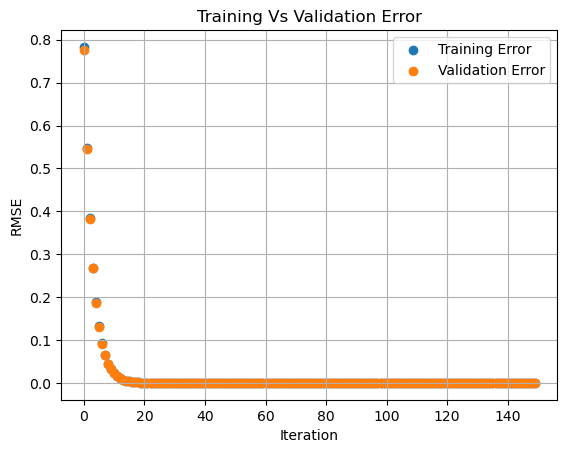

In [111]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

Excluding all PCA components, keeping only categorical values

In [88]:
df_train = pd.read_csv('bike_train_pca.csv',names=columns)
df_valid = pd.read_csv('bike_validation_pca.csv',names=columns)
df_test = pd.read_csv('bike_test_pca.csv',names=columns)

In [89]:
df_train = df_train.iloc[:,1:-2]
df_train.head(5)

,season,holiday,workingday,weather,year,month,day,dayofweek,hour
0,3,0,0,2,2011,9,3,5,0
1,3,0,1,1,2012,8,13,0,14
2,4,0,0,1,2011,11,5,5,17
3,3,0,1,1,2012,8,9,3,19
4,2,0,1,1,2011,4,14,3,6


In [90]:
df_valid = df_valid.iloc[:,1:-2]
df_valid.head(5)

,season,holiday,workingday,weather,year,month,day,dayofweek,hour
0,3,0,1,2,2011,7,7,3,8
1,2,0,0,1,2011,6,11,5,13
2,1,0,1,1,2011,2,14,0,2
3,1,0,1,1,2011,2,8,1,10
4,4,0,0,1,2011,12,4,6,8


In [91]:
y_train = df_train.iloc[:,0].ravel() # Target: 0th column
y_valid = df_valid.iloc[:,0].ravel()

/tmp/ipykernel_22081/4136628259.py:1: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_train = df_train.iloc[:,0].ravel() # Target: 0th column
/tmp/ipykernel_22081/4136628259.py:2: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_valid = df_valid.iloc[:,0].ravel()


In [92]:
regressor = xgb.XGBRegressor(max_depth=5,n_estimators=150)
regressor

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=150, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [93]:
regressor.fit(df_train,y_train, eval_set = [(df_train, y_train), (df_valid, y_valid)])

[0]	validation_0-rmse:0.78329	validation_1-rmse:0.77727
[1]	validation_0-rmse:0.54843	validation_1-rmse:0.54421
[2]	validation_0-rmse:0.38399	validation_1-rmse:0.38103
[3]	validation_0-rmse:0.26885	validation_1-rmse:0.26678
[4]	validation_0-rmse:0.18824	validation_1-rmse:0.18679
[5]	validation_0-rmse:0.13180	validation_1-rmse:0.13078
[6]	validation_0-rmse:0.09228	validation_1-rmse:0.09157
[7]	validation_0-rmse:0.06461	validation_1-rmse:0.06411
[8]	validation_0-rmse:0.04524	validation_1-rmse:0.04489
[9]	validation_0-rmse:0.03167	validation_1-rmse:0.03143
[10]	validation_0-rmse:0.02218	validation_1-rmse:0.02201
[11]	validation_0-rmse:0.01553	validation_1-rmse:0.01541
[12]	validation_0-rmse:0.01087	validation_1-rmse:0.01079
[13]	validation_0-rmse:0.00761	validation_1-rmse:0.00755
[14]	validation_0-rmse:0.00533	validation_1-rmse:0.00529
[15]	validation_0-rmse:0.00373	validation_1-rmse:0.00370
[16]	validation_0-rmse:0.00261	validation_1-rmse:0.00259
[17]	validation_0-rmse:0.00183	validation

[144]	validation_0-rmse:0.00001	validation_1-rmse:0.00001
[145]	validation_0-rmse:0.00001	validation_1-rmse:0.00001
[146]	validation_0-rmse:0.00001	validation_1-rmse:0.00001
[147]	validation_0-rmse:0.00001	validation_1-rmse:0.00001
[148]	validation_0-rmse:0.00001	validation_1-rmse:0.00001
[149]	validation_0-rmse:0.00001	validation_1-rmse:0.00001


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=150, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [94]:
eval_result = regressor.evals_result()

In [95]:
training_rounds = range(len(eval_result['validation_0']['rmse']))
print(training_rounds)

range(0, 150)


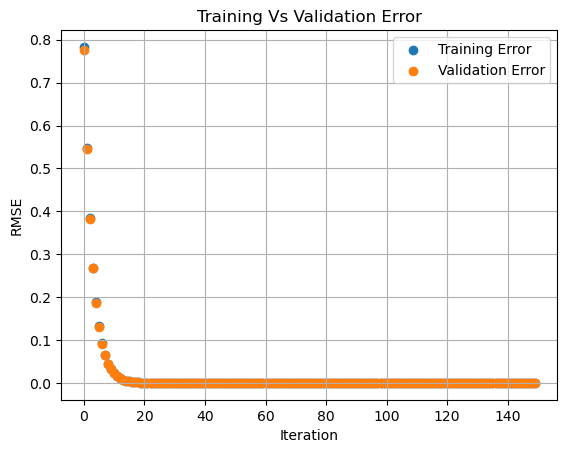

In [96]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()